In [2]:
import os 
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/scenicplus')
from scenicplus.networks import *
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

/tmp/ipykernel_36791/4187200921.py:6: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  scplus_obj = pickle.load(infile)


In [5]:
"""export eRegulons to eGRN network and plot.
"""

import json
import pandas as pd
from typing import Union, Dict, Sequence, Optional, List
import anndata
import scanpy as sc
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from matplotlib.colors import to_rgba, to_hex
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def _format_df_nx(df, key, var):
    """
    A helper function to format differential test results
    """
    df.index = df['names']
    df = pd.DataFrame(df['logfoldchanges'])
    df.columns = [var+'_Log2FC_'+key]
    df.index.name = None
    return df


def _get_log2fc_nx(scplus_obj: 'SCENICPLUS',
                  variable,
                  features,
                  contrast: Optional[str] = 'gene'
                  ):
    """
    A helper function to derive log2fc changes
    """
    if contrast == 'gene':
        adata = anndata.AnnData(X=scplus_obj.X_EXP, obs=pd.DataFrame(
            index=scplus_obj.cell_names), var=pd.DataFrame(index=scplus_obj.gene_names))
    if contrast == 'region':
        adata = anndata.AnnData(X=scplus_obj.X_ACC.T, obs=pd.DataFrame(
            index=scplus_obj.cell_names), var=pd.DataFrame(index=scplus_obj.region_names))
    adata.obs = pd.DataFrame(scplus_obj.metadata_cell[variable])
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, features]
    sc.tl.rank_genes_groups(
        adata, variable, method='wilcoxon', corr_method='bonferroni')
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    diff_list = [_format_df_nx(sc.get.rank_genes_groups_df(
        adata, group=group), group, variable) for group in groups]
    return pd.concat(diff_list, axis=1)


def create_nx_tables(scplus_obj: 'SCENICPLUS',
                     eRegulon_metadata_key: str ='eRegulon_metadata',
                     subset_eRegulons: List = None,
                     subset_regions: List = None,
                     subset_genes: List = None,
                     add_differential_gene_expression: bool = False,
                     add_differential_region_accessibility: bool = False,
                     differential_variable: List =[]):
    """
    A function to format eRegulon data into tables for plotting eGRNs.
    
    Parameters
    ---------
    scplus_obj: SCENICPLUS
        A SCENICPLUS object with eRegulons
    eRegulon_metadata_key: str, optional
        Key where the eRegulon metadata dataframe is stored
    subset_eRegulons: list, optional
        List of eRegulons to subset
    subset_regions: list, optional
        List of regions to subset
    subset_genes: list, optional
        List of genes to subset
    add_differential_gene_expression: bool, optional
        Whether to calculate differential gene expression logFC for a given variable
    add_differential_region_accessibility: bool, optional
        Whether to calculate differential region accessibility logFC for a given variable
    differential_variable: list, optional
        Variable to calculate differential gene expression or region accessibility.
        
    Return
    ---------
    A dictionary with edge feature tables ('TF2G', 'TF2R', 'R2G') and node feature tables ('TF', 'Gene', 'Region')
    """
    er_metadata = scplus_obj.uns[eRegulon_metadata_key].copy()
    if subset_eRegulons is not None:
        subset_eRegulons = [x + '_[^a-zA-Z0-9]' for x in subset_eRegulons]
        er_metadata = er_metadata[er_metadata['Region_signature_name'].str.contains(
            '|'.join(subset_eRegulons))]
    if subset_regions is not None:
        er_metadata = er_metadata[er_metadata['Region'].isin(subset_regions)]
    if subset_genes is not None:
        er_metadata = er_metadata[er_metadata['Gene'].isin(subset_genes)]
    nx_tables = {}
    nx_tables['Edge'] = {}
    nx_tables['Node'] = {}
    # Generate edge tables
    r2g_columns = [x for x in er_metadata.columns if 'R2G' in x]
    tf2g_columns = [x for x in er_metadata.columns if 'TF2G' in x]
    nx_tables['Edge']['TF2R'] = er_metadata[er_metadata.columns.difference(
        r2g_columns + tf2g_columns)].drop('Gene', axis=1).drop_duplicates()
    nx_tables['Edge']['TF2R'] = nx_tables['Edge']['TF2R'][['TF', 'Region'] +
                                                          nx_tables['Edge']['TF2R'].columns.difference(['TF', 'Region']).tolist()]
    nx_tables['Edge']['R2G'] = er_metadata[er_metadata.columns.difference(
        tf2g_columns)].drop('TF', axis=1).drop_duplicates()
    nx_tables['Edge']['R2G'] = nx_tables['Edge']['R2G'][['Region', 'Gene'] +
                                                        nx_tables['Edge']['R2G'].columns.difference(['Region', 'Gene']).tolist()]
    nx_tables['Edge']['TF2G'] = er_metadata[er_metadata.columns.difference(
        r2g_columns)].drop('Region', axis=1).drop_duplicates()
    nx_tables['Edge']['TF2G'] = nx_tables['Edge']['TF2G'][['TF', 'Gene'] +
                                                          nx_tables['Edge']['TF2G'].columns.difference(['TF', 'Gene']).tolist()]
    # Generate node tables
    tfs = list(set(er_metadata['TF']))
    nx_tables['Node']['TF'] = pd.DataFrame(
        'TF', index=tfs, columns=['Node_type'])
    nx_tables['Node']['TF']['TF'] = tfs
    genes = list(set(er_metadata['Gene']))
    genes = [x for x in genes if x not in tfs]
    nx_tables['Node']['Gene'] = pd.DataFrame(
        'Gene', index=genes, columns=['Node_type'])
    nx_tables['Node']['Gene']['Gene'] = genes
    regions = list(set(er_metadata['Region']))
    nx_tables['Node']['Region'] = pd.DataFrame(
        'Region', index=regions, columns=['Node_type'])
    nx_tables['Node']['Region']['Region'] = regions
    # Add gene logFC
    if add_differential_gene_expression is True:
        for var in differential_variable:
            nx_tables['Node']['TF'] = pd.concat([nx_tables['Node']['TF'], _get_log2fc_nx(
                scplus_obj, var, nx_tables['Node']['TF'].index.tolist(), contrast='gene')], axis=1)
            nx_tables['Node']['Gene'] = pd.concat([nx_tables['Node']['Gene'], _get_log2fc_nx(
                scplus_obj, var, nx_tables['Node']['Gene'].index.tolist(), contrast='gene')], axis=1)
    if add_differential_region_accessibility is True:
        for var in differential_variable:
            nx_tables['Node']['Region'] = pd.concat([nx_tables['Node']['Region'], _get_log2fc_nx(
                scplus_obj, var, nx_tables['Node']['Region'].index.tolist(), contrast='region')], axis=1)
    return nx_tables


def _format_nx_table_internal(nx_tables, table_type, table_id, color_by={}, transparency_by={}, size_by={}, shape_by={}, label_size_by={}, label_color_by={}):
    """
    A helper function to format edge and node tables into graphs
    """
    nx_tb = nx_tables[table_type][table_id]
    # Color
    if table_id in color_by.keys():
        if 'fixed_color' not in color_by[table_id].keys():
            color_var = nx_tables[table_type][table_id][color_by[table_id]['variable']]
            if 'category_color' in color_by[table_id].keys():
                if color_by[table_id]['category_color'] is None:
                    random.seed(555)
                    categories = set(color_var)
                    color = list(map(
                        lambda i: "#" +
                        "%06x" % random.randint(
                            0, 0xFFFFFF), range(len(categories))
                    ))
                    color_dict = dict(zip(categories, color))
                else:
                    color_dict = color_by[table_id]['category_color']
                color = color_var.apply(
                    lambda x: to_rgba(color_dict[x])).to_numpy()
            elif 'continuous_color' in color_by[table_id].keys():
                if color_by[table_id]['continuous_color'] is None:
                    color_map = 'viridis'
                else:
                    color_map = color_by[table_id]['continuous_color']
                if 'v_min' in color_by[table_id].keys():
                    v_min = color_by[table_id]['v_min']
                else:
                    v_min = None
                if 'v_max' in color_by[table_id].keys():
                    v_max = color_by[table_id]['v_max']
                else:
                    v_max = None
                color = _get_colors(color_var, color_map, v_min, v_max)
        else:
            color = np.array([color_by[table_id]['fixed_color']]
                             * nx_tables[table_type][table_id].shape[0])
    else:
        color = np.array([to_rgba('grey')] *
                         nx_tables[table_type][table_id].shape[0])

    # Transparency
    if table_id in transparency_by.keys():
        if 'fixed_alpha' not in transparency_by[table_id]['variable']:
            transparency_var = nx_tables[table_type][table_id][transparency_by[table_id]['variable']]
            if 'v_min' in transparency_by[table_id].keys():
                v_min = transparency_by[table_id]['v_min']
            else:
                v_min = None
            if 'v_max' in transparency_by[table_id].keys():
                v_max = transparency_by[table_id]['v_max']
            else:
                v_max = None
            if 'min_alpha' in transparency_by[table_id].keys():
                min_alpha = transparency_by[table_id]['min_alpha']
            else:
                min_alpha = 0.5
            norm = plt.Normalize(v_min, v_max)
            x = norm(transparency_var)
            x[x < min_alpha] = min_alpha
            color[:, -1] = x
        else:
            for i in range(0, len(color)):
                c = list(color[i])
                c[-1] = transparency_by[table_id]['fixed_alpha']
                color[i] = tuple(c)


    # Size/Width
    if table_id in size_by.keys():
        if 'fixed_size' not in size_by[table_id].keys():
            sw_var = nx_tables[table_type][table_id][size_by[table_id]
                                                     ['variable']].to_numpy().flatten('F')
            if 'min_size' in size_by[table_id].keys():
                p_min = size_by[table_id]['min_size']
            else:
                p_min = 3
            if 'max_size' in size_by[table_id].keys():
                p_max = size_by[table_id]['max_size']
            else:
                p_max = 10
            s_min = sw_var[sw_var != 0].min()
            s_max = sw_var.max()
            sw_var[sw_var != 0] = p_min + \
                (sw_var[sw_var != 0] - s_min) * \
                ((p_max - p_min) / (s_max - s_min))
        else:
            sw_var = [size_by[table_id]['fixed_size']] * \
                nx_tables[table_type][table_id].shape[0]
    else:
        sw_var = [1] * nx_tables[table_type][table_id].shape[0]

    # Node shape
    if table_id in shape_by.keys():
        if 'fixed_shape' not in shape_by[table_id].keys():
            if not 'categorical_shape' in shape_by[table_id].keys():
                print(
                    'No categorical_shape dictionary provided, making all nodes circular!')
                shape_var = ['circular'] * \
                    nx_tables[table_type][table_id].shape[0]
            else:
                shape_dict = shape_by[table_id]['categorical_shape']
                shape_var = shape_var.apply(lambda x: shape_dict[x]).to_numpy()
        else:
            shape_var = np.array(
                [shape_by[table_id]['fixed_shape']]*nx_tables[table_type][table_id].shape[0])
    else:
        shape_var = ['ellipse'] * nx_tables[table_type][table_id].shape[0]

    # Label size
    if table_id in label_size_by.keys():
        if 'fixed_label_size' not in label_size_by[table_id].keys():
            if not 'categorical_label_size' in label_size_by[table_id].keys():
                print(
                    'categorical_label_size dictionary provided, using size 14 for all nodes!')
                label_size_var = 14 * nx_tables[table_type][table_id].shape[0]
            else:
                label_size_dict = label_size_by[table_id]['categorical_label_size']
                label_size_var = label_size_var.apply(
                    lambda x: label_size_var[x]).to_numpy()
        else:
            label_size_var = np.array(
                [label_size_by[table_id]['fixed_label_size']]*nx_tables[table_type][table_id].shape[0])
    else:
        label_size_var = [14] * nx_tables[table_type][table_id].shape[0]

    # Label color
    if table_id in label_color_by.keys():
        if 'fixed_label_color' not in label_color_by[table_id].keys():
            if not 'categorical_label_color' in label_color_by[table_id].keys():
                print(
                    'categorical_label_color dictionary provided, using black for all nodes!')
                label_color_var = np.array(
                    [to_rgba('black')]*nx_tables[table_type][table_id].shape[0])
            else:
                label_color_dict = label_color_by[table_id]['categorical_label_color']
                label_color_var = label_color_var.apply(
                    lambda x: to_rgba(label_color_var[x])).to_numpy()
        else:
            label_color_var = np.array(
                [label_color_by[table_id]['fixed_label_color']]*nx_tables[table_type][table_id].shape[0])
    else:
        label_color_var = np.array(
            [to_rgba('black')]*nx_tables[table_type][table_id].shape[0])

    color = [to_hex(x, keep_alpha=True) for x in color]
    label_color_var = [to_hex(x, keep_alpha=True) for x in label_color_var]
    if table_type == 'Edge':
        dt1 = nx_tb.iloc[:, 0:2].reset_index(drop=True)
        dt2 = pd.DataFrame([color, sw_var]).T.reset_index(drop=True)
    else:
        dt1 = nx_tb.iloc[:, 0:2].reset_index(drop=True)
        dt2 = pd.DataFrame([color, sw_var, shape_var, label_size_var,
                           label_color_var]).T.reset_index(drop=True)

    dt = pd.concat([dt1, dt2], axis=1)
    color = dt.iloc[:,2]
    dt['color_rgb'] = [to_hex(to_rgba(x)) for x in color]
    dt['color_alpha'] = [to_rgba(x)[3] for x in color]
    scaler = MinMaxScaler(feature_range=(200,255))
    dt['color_alpha'] = scaler.fit_transform(np.array(dt['color_alpha']).reshape(-1,1))
    if len(set(dt['color_alpha'])) == 1:
        dt['color_alpha'] = [255]*dt.shape[0]
    if table_type == 'Edge':
        dt.columns = ['source', 'target', 'color', 'width', 'color_rgb', 'color_alpha']
    else:
        color = dt.iloc[:,6]
        dt['font_color_rgb'] = [to_hex(to_rgba(x)) for x in color]
        dt['font_color_alpha'] = [to_rgba(x)[3] for x in color]
        dt['font_color_alpha'] = scaler.fit_transform(np.array(dt['font_color_alpha']).reshape(-1,1))
        if len(set(dt['font_color_alpha'])) == 1:
            dt['font_color_alpha'] = [255]*dt.shape[0]
        dt.columns = ['group', 'label', 'color',
                      'size', 'shape', 'font_size', 'font_color', 'color_rgb', 'color_alpha',
                      'font_color_rgb', 'font_color_alpha']
    return dt


def _get_colors(inp, cmap_name, vmin=None, vmax=None):
    """
    A function to get color values from a continuous vector and a color map
    """
    color_map = cm.get_cmap(cmap_name)
    norm = plt.Normalize(vmin, vmax)
    return color_map(norm(inp))


def create_nx_graph(nx_tables: Dict,
                    use_edge_tables: List = ['TF2R', 'R2G'],
                    color_edge_by: Dict ={},
                    transparency_edge_by: Dict ={},
                    width_edge_by: Dict = {},
                    color_node_by: Dict = {},
                    transparency_node_by: Dict = {},
                    size_node_by: Dict = {},
                    shape_node_by: Dict = {},
                    label_size_by: Dict = {},
                    label_color_by: Dict = {},
                    layout: str = 'concentrical_layout',
                    lc_dist_genes: float = 0.8,
                    lc_dist_TF: float = 0.1,
                    scale_position_by: float = 250):
    """
    Format node/edge feature tables into a graph
    
    Parameters
    ---------
    nx_tables: Dict
        Dictionary with node/edge feature tables as produced by `create_nx_tables`
    use_edge_tables: List, optional
        List of edge tables to use
    color_edge_by: Dict, optional
        A dictionary containing for a given edge key the variable and color map to color edges by.
        If the variable is categorical, the entry 'categorical_color' can be provided as a dictionary with
        category: color. If it is a continuous variable a color map can be provided as `continuous_color` and
        entried v_max and v_min can be provided to control the min and max values of the scale. Alternatively,
        one fixed color can use by using 'fixed_color' as variable, alterntively adding an entry fixed_color: color
        to the dictionary.
    transparency_edge_by: Dict, optional
        A dictionary containing for a given edge key the variable and the max and min alpha values. The variable
        name has to be provided (only continuous variables accepted), together with v_max/v_mix parameters if
        desired. Alternatively, one fixed alpha can use by using 'fixed_alpha' as variable, alterntively adding an
        entry fixed_alpha: size to the dictionary.
    width_edge_by: Dict, optional
        A dictionary containing for a given edge key the variable and the max and min sizes. The variable
        name has to be provided (only continuous variables accepted), together with max_size/min_size parameters if
        desired. Alternatively, one fixed size can use by using 'fixed_size' as variable, alterntively adding an
        entry fixed_size: size to the dictionary.
    color_node_by: Dict, optional
        A dictionary containing for a given node key the variable and color map to color edges by.
        If the variable is categorical, the entry 'categorical_color' can be provided as a dictionary with
        category: color. If it is a continuous variable a color map can be provided as `continuous_color` and
        entried v_max and v_min can be provided to control the min and max values of the scale. Alternatively,
        one fixed color can use by using 'fixed_color' as variable, alterntively adding an entry fixed_color: color
        to the dictionary.
    transparency_node_by: Dict, optional
        A dictionary containing for a given node key the variable and the max and min alpha values. The variable
        name has to be provided (only continuous variables accepted), together with v_max/v_mix parameters if
        desired. Alternatively, one fixed alpha can use by using 'fixed_alpha' as variable, alterntively adding an
        entry fixed_alpha: size to the dictionary.
    size_node_by: Dict, optional
        A dictionary containing for a given node key the variable and the max and min sizes. The variable
        name has to be provided (only continuous variables accepted), together with max_size/min_size parameters if
        desired. Alternatively, one fixed size can use by using 'fixed_size' as variable, alterntively adding an
        entry fixed_size: size to the dictionary.
    shape_node_by: Dict, optional
        A dictionary containing for a given node key the variable and shapes. The variable
        name has to be provided (only categorical variables accepted). Alternatively, one fixed shape can use by
        using 'fixed_shape' as variable, alterntively adding an entry fixed_shape: size to the dictionary.
    label_size_node_by: Dict, optional
        A dictionary containing for a given node key the variable and the max and min sizes. The variable
        name has to be provided (only continuous variables accepted), together with max_size/min_size parameters if
        desired. Alternatively, one fixed size can use by using 'fixed_label_size' as variable, alterntively adding an
        entry fixed_label_size: size to the dictionary.
    label_color_node_by: Dict, optional
        A dictionary containing for a given node key the variable and a color dictionary. The variable
        name has to be provided (only categorical variables accepted), together with a color dictionary if
        desired. Alternatively, one fixed color can use by using 'fixed_label_color' as variable, alterntively adding an
        entry fixed_label_color: size to the dictionary.
    layout: str, optional
        Layout to use. Options are: 'concentrical_layout' (SCENIC+ custom layout) or kamada_kawai_layout (from networkx).
    lc_dist_genes: float, optional
        Distance between regions and genes. Only used if using concentrical_layout.
    lc_dist_TF: float, optional
        Distance between TF and regions. Only used if using concentrical_layout.
    scale_position_by: int, optional
        Value to scale positions for visualization in pyvis.
        
    Return
    ---------
    A networkx graph, positions, and node/edges feature tables.
    """
    # Get node table names
    use_node_tables = []
    if 'TF2R' in use_edge_tables:
        use_node_tables = ['TF', 'Region'] + use_node_tables
    if 'TF2G' in use_edge_tables:
        use_node_tables = ['TF', 'Gene'] + use_node_tables
    if 'R2G' in use_edge_tables:
        use_node_tables = ['Region', 'Gene'] + use_node_tables
    use_node_tables = sorted(list(set(use_node_tables)), reverse=True)

    # Create graph
    edge_tables = pd.concat([_format_nx_table_internal(
        nx_tables, 'Edge', x, color_edge_by, transparency_edge_by, width_edge_by, {}) for x in use_edge_tables])
    G = nx.from_pandas_edgelist(edge_tables, edge_attr=True)
    # Add node tables
    node_tables = pd.concat([_format_nx_table_internal(nx_tables, 'Node', x, color_node_by, transparency_node_by,
                            size_node_by, shape_node_by, label_size_by, label_color_by) for x in use_node_tables])
    node_tables.index = node_tables['label']
    node_tables_d = node_tables.to_dict()
    for key in node_tables_d.keys():
            nx.set_node_attributes(G, node_tables_d[key], name=key)
    nx.set_node_attributes(G, node_tables_d['label'], name='title')
    font_nt_d = node_tables[['font_size', 'font_color']]
    font_nt_d.columns = ['size', 'color']
    font_nt_d = font_nt_d.to_dict(orient='index')
    nx.set_node_attributes(G, font_nt_d, name='font')
    if layout == 'concentrical_layout':
        pos = concentrical_layout(G, dist_genes=lc_dist_genes, dist_TF=lc_dist_TF)
    else:
        pos = nx.kamada_kawai_layout(G)
        
    x_pos_dict = {x:pos[x][0]*scale_position_by for x in pos.keys()}
    y_pos_dict = {x:pos[x][1]*scale_position_by for x in pos.keys()}
    fixed_dict = {x:{'fixed.x': True, 'fixed.y': True} for x in pos.keys()}
    nx.set_node_attributes(G, x_pos_dict, name='x')
    nx.set_node_attributes(G, y_pos_dict, name='y')
    nx.set_node_attributes(G, fixed_dict, name='fixed')
        
    return G, pos, edge_tables, node_tables

def plot_networkx(G, pos):
    """
    A function to plot networks with networkx
    
    Parameters
    ---------
    G: Graph
        A networkx graph
    pos: Dict
        Position values
    """
    nx.draw_networkx_nodes(G, pos, node_color=nx.get_node_attributes(G,'color').values(),
                           node_size=list(nx.get_node_attributes(G,'size').values()),
                           node_shape = 'D')
    nx.draw_networkx_edges(G, pos, edge_color = nx.get_edge_attributes(G,'color').values(),
                          width = list(nx.get_edge_attributes(G,'width').values()))
    fontsize_d = {y:x['size'] for x,y in zip(list(nx.get_node_attributes(G,'font').values()),list(nx.get_node_attributes(G,'label').values())) if x['size'] != 0.0}
    fontcolor_d = {y:x['color'] for x,y in zip(list(nx.get_node_attributes(G,'font').values()),list(nx.get_node_attributes(G,'label').values())) if x['size'] != 0.0}
    for node, (x, y) in pos.items():
        if node in fontsize_d.keys():
            plt.text(x, y, node, fontsize=fontsize_d[node], color=fontcolor_d[node],  ha='center', va='center')
    ax = plt.gca()
    ax.margins(0.11)
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def _distance(p1, p2):
    """
    Helper function for custom layout
    """
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]

    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


def _pairwise_distance(points):
    """
    Helper function for custom layout
    """
    distances = np.zeros((points.shape[0], points.shape[0]))
    for i in range(points.shape[0]):
        for j in range(points.shape[0]):
            distances[i, j] = _distance(points[i], points[j])
    np.fill_diagonal(distances, np.NINF)
    return distances


def _line_two_points(p1, p2, return_func=True):
    """
    Helper function for custom layout
    """
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]

    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    if return_func:
        return lambda x: m * x + b
    else:
        return m, b


def _line_slope_point(m, p, return_func=True):
    """
    Helper function for custom layout
    """
    x = p[0]
    y = p[1]
    b = y - m * x

    if return_func:
        return lambda x: m * x + b
    else:
        return m, b

def concentrical_layout(G,
               dist_genes=1,
               dist_TF=0.1):
    """
    Generate custom concentrical layout
    
    Parameters
    ---------
    G: Graph
        A networkx graph
    dist_genes: int, optional
        Distance from the regions to the genes
    dist_TF
        Distance from the TF to the regions
    """
    node_type = nx.get_node_attributes(G, 'group')
    TF_nodes = [n for n in G.nodes if node_type[n] == 'TF']
    region_nodes = [n for n in G.nodes if node_type[n] == 'Region']
    gene_nodes = [n for n in G.nodes if node_type[n] == 'Gene']

    # get regions with TFs as target
    tmp = pd.DataFrame(list(G.edges))
    regions_targetting_TFs = tmp.loc[np.isin(tmp[1], TF_nodes), 0].to_list()
    del(tmp)
    region_nodes = list(set(region_nodes) - set(regions_targetting_TFs))

    # layout regions in a circle
    n_region_nodes = len(region_nodes)

    theta = np.linspace(0, 1, n_region_nodes + 1)[:-1] * 2 * np.pi
    theta = theta.astype(np.float32)
    pos_regions = np.column_stack(
        [np.cos(theta), np.sin(theta), np.zeros((n_region_nodes, 0))]
    )

    # sort regions by target
    source_target_dict = {}
    target_source_dict = {}
    for edge in G.edges:
        source = edge[0]
        target = edge[1]

        if source in source_target_dict.keys():
            if target not in source_target_dict[source]:
                source_target_dict[source].append(target)
        else:
            source_target_dict[source] = [target]

        if target in target_source_dict.keys():
            if source not in target_source_dict[target]:
                target_source_dict[target].append(source)
        else:
            target_source_dict[target] = [source]

    region_nodes = sorted(region_nodes, key=lambda x: target_source_dict[x][0])
    pos_regions = dict(zip(region_nodes, pos_regions))

    # layout target genes in concentric circle around regions
    pos_genes = {}
    additional_genes_to_position = []
    for gene in gene_nodes:
        # get regions targetting this gene and their position
        regions = target_source_dict[gene]
        if all([r in regions_targetting_TFs for r in regions]):
            additional_genes_to_position.append(gene)
            continue
        pos_regions_gene = np.array(
            [pos_regions[r] for r in regions if r not in regions_targetting_TFs])
        if len(regions) > 1:
            # get the positions which are furthest apart and "draw" a line through them
            pairwise_distances = _pairwise_distance(pos_regions_gene)
            furthest_points = np.unravel_index(
                pairwise_distances.argmax(), pairwise_distances.shape)
            m, b = _line_two_points(
                pos_regions_gene[furthest_points[0]], pos_regions_gene[furthest_points[1]], return_func=False)
            # draw a perpendicular line through the first line and the mean position
            p_mean = pos_regions_gene.mean(0)
            m, b = _line_slope_point(-1/m, p_mean, return_func=False)
            # get the point which is a distance dist_genes away from point p_mean
            p_new = [p_mean[0] - dist_genes * np.sqrt(1 / (1 + m**2)),
                     p_mean[1] - m * dist_genes * np.sqrt(1 / (1 + m**2))]
            # check if point is within the circle, otherwise take the other point (radius of the circle is 1)
            if p_new[0]**2 + p_new[1]**2 < 1:
                p_new = [p_mean[0] + dist_genes * np.sqrt(1 / (1 + m**2)),
                         p_mean[1] + m * dist_genes * np.sqrt(1 / (1 + m**2))]
        else:
            # draw line trough origin and pos of region
            m, b = _line_two_points(pos_regions_gene[0], [
                                    0, 0], return_func=False)
            # get the point which is a distance dist_genes away from point pos_regions_gene
            p_new = [pos_regions_gene[0][0] - dist_genes * np.sqrt(1 / (1 + m**2)),
                     pos_regions_gene[0][1] - m * dist_genes * np.sqrt(1 / (1 + m**2))]
            # check if point is within the circle, otherwise take the other point (radius of the circle is 1)
            if p_new[0]**2 + p_new[1]**2 < 1:
                p_new = [pos_regions_gene[0][0] + dist_genes * np.sqrt(1 / (1 + m**2)),
                         pos_regions_gene[0][1] + m * dist_genes * np.sqrt(1 / (1 + m**2))]
        pos_genes[gene] = np.array(p_new)

    pos_TF = {}
    for TF in TF_nodes:
        # get regions targetted by this TF and their position
        regions = source_target_dict[TF]
        if all([r in regions_targetting_TFs for r in regions]):
            additional_genes_to_position.append(TF)
            continue
        pos_regions_TF = np.array(
            [pos_regions[r] for r in regions if r not in regions_targetting_TFs])
        if len(regions) > 1:
            # get the positions which are furthest apart and "draw" a line through them
            pairwise_distances = _pairwise_distance(pos_regions_TF)
            furthest_points = np.unravel_index(
                pairwise_distances.argmax(), pairwise_distances.shape)
            m, b = _line_two_points(
                pos_regions_TF[furthest_points[0]], pos_regions_TF[furthest_points[1]], return_func=False)
            # draw a perpendicular line through the first line and the mean position
            p_mean = pos_regions_TF.mean(0)
            m, b = _line_slope_point(-1/m, p_mean, return_func=False)
            # get the point which is a distance dist_genes away from point p_mean
            p_new = [p_mean[0] - dist_TF * np.sqrt(1 / (1 + m**2)),
                     p_mean[1] - m * dist_TF * np.sqrt(1 / (1 + m**2))]
            # check if point is within the circle, otherwise take the other point (radius of the circle is 1)
            if p_new[0]**2 + p_new[1]**2 > 1:
                p_new = [p_mean[0] + dist_TF * np.sqrt(1 / (1 + m**2)),
                         p_mean[1] + m * dist_TF * np.sqrt(1 / (1 + m**2))]
        else:
            # draw line trough origin and pos of region
            m, b = _line_two_points(
                pos_regions_TF[0], [0, 0], return_func=False)
            # get the point which is a distance dist_genes away from point pos_regions_gene
            p_new = [pos_regions_TF[0][0] - dist_TF * np.sqrt(1 / (1 + m**2)),
                     pos_regions_TF[0][1] - m * dist_TF * np.sqrt(1 / (1 + m**2))]
            # check if point is within the circle, otherwise take the other point (radius of the circle is 1)
            if p_new[0]**2 + p_new[1]**2 < 1:
                p_new = [pos_regions_TF[0][0] + dist_TF * np.sqrt(1 / (1 + m**2)),
                         pos_regions_TF[0][1] + m * dist_TF * np.sqrt(1 / (1 + m**2))]
        pos_TF[TF] = np.array(p_new)

    # layout TF nodes within circle
    #G_TF = G.subgraph(nodes = [*TF_nodes, *regions_targetting_TFs, *additional_genes_to_position])
    #additional_genes_to_position_init = {gene: [random.uniform(0, 1), random.uniform(0, 1)] for gene in additional_genes_to_position}
    #pos_TF = nx.spring_layout(G_TF, scale = 0.7, pos = {**pos_TF, **additional_genes_to_position_init})
    G_add = G.subgraph(nodes=additional_genes_to_position)
    pos_add = nx.spring_layout(G_add, scale=0.1)

    G_regions_TF = G.subgraph(nodes=[*regions_targetting_TFs, *TF_nodes])
    pos_regions_TF = nx.spring_layout(G_regions_TF, scale=1)
    pos_regions_TF = {k: pos_regions_TF[k] for k in pos_regions_TF.keys(
    ) if k in regions_targetting_TFs}

    return {**pos_TF, **pos_regions, **pos_genes, **pos_add, **pos_regions_TF}
    
def export_to_cytoscape(G, pos, out_file, pos_scaling_factor=200, size_scaling_factor=1):
    """
    A function to export to cytoscape
    """
    cy = nx.cytoscape_data(G)
    for n in cy["elements"]["nodes"]:
        for k, v in n.items():
            v["label"] = v.pop("value")
    for n, p in zip(cy["elements"]["nodes"], pos.values()):
        n["position"] = {"x": int(p[0] * POS_SCALING_FACTOR), "y": int(p[1] * POS_SCALING_FACTOR)}
    for n in cy["elements"]["nodes"]:
        n['data']['font_size'] = int(n['data']['font_size'])
        n['data']['size'] = n['data']['size']*SIZE_SCALING_FACTOR
        n['data']['shape'] = n['data']['shape'].capitalize()
    json_string = json.dumps(cy, indent = 2)
    with open(out_file, 'w') as outfile:
        outfile.write(json_string) 


In [17]:
subset_genes = ['PLP1', 'SOX8', 'EPN1', 'OLIG1', 'MOG', 'OLIG2', 'SOX10', 'PLLP', 'PBX3', 'LRRN1', 'UBL8']
nx_tables = create_nx_tables(scplus_obj,
                    eRegulon_metadata_key = 'eRegulon_metadata',
                    subset_eRegulons = ['SOX10', 'OLIG2', 'TCF12'],
                    subset_regions = None,
                    subset_genes = subset_genes,
                    add_differential_gene_expression = True,
                    add_differential_region_accessibility = True,
                    differential_variable = ['ACC_Seurat_cell_type', 'ACC_VSN_cell_type'])

G_c, pos_c, edge_tables_c, node_tables_c = create_nx_graph(nx_tables, 
                   use_edge_tables = ['TF2R','R2G'],
                   color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : {'SOX10': 'Orange', 'OLIG2': 'Purple', 'TCF12': 'Red'}},
                                    'R2G': {'variable' : 'R2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'R2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'R2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {'TF': {'variable': 'TF', 'category_color' : {'SOX10': 'Orange', 'OLIG2': 'Purple',  'TCF12': 'Red'}},
                                    'Gene': {'variable': 'ACC_Seurat_cell_type_Log2FC_MOL', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'ACC_Seurat_cell_type_Log2FC_MOL', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'ACC_Seurat_cell_type_Log2FC_MOL', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'ACC_Seurat_cell_type_Log2FC_MOL', 'min_alpha': 0.1},
                                    'TF': {'variable': 'fixed_alpha', 'fixed_alpha': 1}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 15},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 10}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='concentrical_layout',
                   scale_position_by=250)

/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitMod

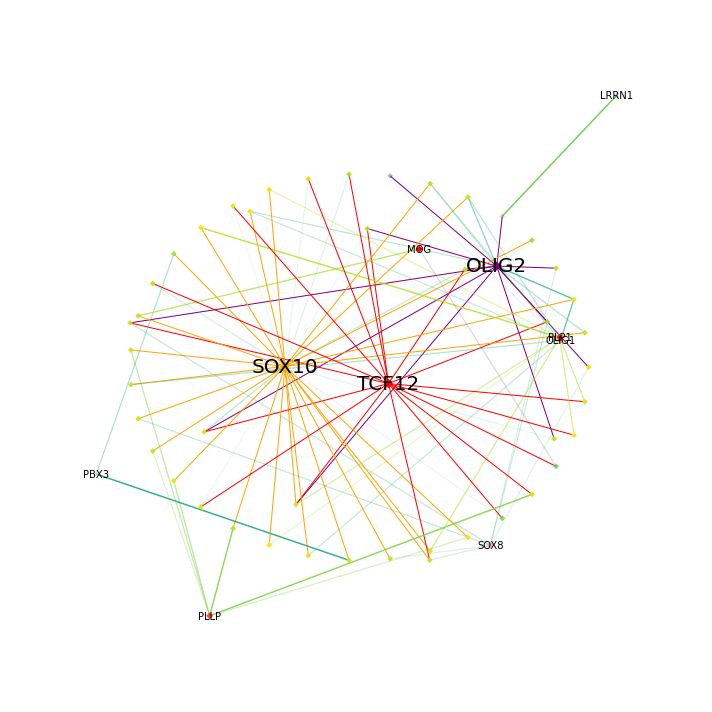

In [18]:
plt.figure(figsize=(10,10))
plot_networkx(G_c, pos_c)

In [43]:
"""export eRegulons to eGRN network and plot.
"""

import json
import pandas as pd
from typing import Union, Dict, Sequence, Optional, List
import anndata
import scanpy as sc
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from matplotlib.colors import to_rgba, to_hex
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def _format_df_nx(df, key, var):
    """
    A helper function to format differential test results
    """
    df.index = df['names']
    df = pd.DataFrame(df['logfoldchanges'])
    df.columns = [var+'_Log2FC_'+key]
    df.index.name = None
    return df


def _get_log2fc_nx(scplus_obj: 'SCENICPLUS',
                  variable,
                  features,
                  contrast: Optional[str] = 'gene'
                  ):
    """
    A helper function to derive log2fc changes
    """
    if contrast == 'gene':
        adata = anndata.AnnData(X=scplus_obj.X_EXP, obs=pd.DataFrame(
            index=scplus_obj.cell_names), var=pd.DataFrame(index=scplus_obj.gene_names))
    if contrast == 'region':
        adata = anndata.AnnData(X=scplus_obj.X_ACC.T, obs=pd.DataFrame(
            index=scplus_obj.cell_names), var=pd.DataFrame(index=scplus_obj.region_names))
    adata.obs = pd.DataFrame(scplus_obj.metadata_cell[variable])
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, features]
    sc.tl.rank_genes_groups(
        adata, variable, method='wilcoxon', corr_method='bonferroni')
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    diff_list = [_format_df_nx(sc.get.rank_genes_groups_df(
        adata, group=group), group, variable) for group in groups]
    return pd.concat(diff_list, axis=1)


def create_nx_tables(scplus_obj: 'SCENICPLUS',
                     eRegulon_metadata_key: str ='eRegulon_metadata',
                     subset_eRegulons: List = None,
                     subset_regions: List = None,
                     subset_genes: List = None,
                     add_differential_gene_expression: bool = False,
                     add_differential_region_accessibility: bool = False,
                     differential_variable: List =[]):
    """
    A function to format eRegulon data into tables for plotting eGRNs.
    
    Parameters
    ---------
    scplus_obj: SCENICPLUS
        A SCENICPLUS object with eRegulons
    eRegulon_metadata_key: str, optional
        Key where the eRegulon metadata dataframe is stored
    subset_eRegulons: list, optional
        List of eRegulons to subset
    subset_regions: list, optional
        List of regions to subset
    subset_genes: list, optional
        List of genes to subset
    add_differential_gene_expression: bool, optional
        Whether to calculate differential gene expression logFC for a given variable
    add_differential_region_accessibility: bool, optional
        Whether to calculate differential region accessibility logFC for a given variable
    differential_variable: list, optional
        Variable to calculate differential gene expression or region accessibility.
        
    Return
    ---------
    A dictionary with edge feature tables ('TF2G', 'TF2R', 'R2G') and node feature tables ('TF', 'Gene', 'Region')
    """
    er_metadata = scplus_obj.uns[eRegulon_metadata_key].copy()
    if subset_eRegulons is not None:
        subset_eRegulons = [x + '_[^a-zA-Z0-9]' for x in subset_eRegulons]
        er_metadata = er_metadata[er_metadata['Region_signature_name'].str.contains(
            '|'.join(subset_eRegulons))]
    if subset_regions is not None:
        er_metadata = er_metadata[er_metadata['Region'].isin(subset_regions)]
    if subset_genes is not None:
        er_metadata = er_metadata[er_metadata['Gene'].isin(subset_genes)]
    nx_tables = {}
    nx_tables['Edge'] = {}
    nx_tables['Node'] = {}
    # Generate edge tables
    r2g_columns = [x for x in er_metadata.columns if 'R2G' in x]
    tf2g_columns = [x for x in er_metadata.columns if 'TF2G' in x]
    nx_tables['Edge']['TF2R'] = er_metadata[er_metadata.columns.difference(
        r2g_columns + tf2g_columns)].drop('Gene', axis=1).drop_duplicates()
    nx_tables['Edge']['TF2R'] = nx_tables['Edge']['TF2R'][['TF', 'Region'] +
                                                          nx_tables['Edge']['TF2R'].columns.difference(['TF', 'Region']).tolist()]
    nx_tables['Edge']['R2G'] = er_metadata[er_metadata.columns.difference(
        tf2g_columns)].drop('TF', axis=1).drop_duplicates()
    nx_tables['Edge']['R2G'] = nx_tables['Edge']['R2G'][['Region', 'Gene'] +
                                                        nx_tables['Edge']['R2G'].columns.difference(['Region', 'Gene']).tolist()]
    nx_tables['Edge']['TF2G'] = er_metadata[er_metadata.columns.difference(
        r2g_columns)].drop('Region', axis=1).drop_duplicates()
    nx_tables['Edge']['TF2G'] = nx_tables['Edge']['TF2G'][['TF', 'Gene'] +
                                                          nx_tables['Edge']['TF2G'].columns.difference(['TF', 'Gene']).tolist()]
    # Generate node tables
    tfs = list(set(er_metadata['TF']))
    nx_tables['Node']['TF'] = pd.DataFrame(
        'TF', index=tfs, columns=['Node_type'])
    nx_tables['Node']['TF']['TF'] = tfs
    genes = list(set(er_metadata['Gene']))
    genes = [x for x in genes if x not in tfs]
    nx_tables['Node']['Gene'] = pd.DataFrame(
        'Gene', index=genes, columns=['Node_type'])
    nx_tables['Node']['Gene']['Gene'] = genes
    regions = list(set(er_metadata['Region']))
    nx_tables['Node']['Region'] = pd.DataFrame(
        'Region', index=regions, columns=['Node_type'])
    nx_tables['Node']['Region']['Region'] = regions
    # Add gene logFC
    if add_differential_gene_expression is True:
        for var in differential_variable:
            nx_tables['Node']['TF'] = pd.concat([nx_tables['Node']['TF'], _get_log2fc_nx(
                scplus_obj, var, nx_tables['Node']['TF'].index.tolist(), contrast='gene')], axis=1)
            nx_tables['Node']['Gene'] = pd.concat([nx_tables['Node']['Gene'], _get_log2fc_nx(
                scplus_obj, var, nx_tables['Node']['Gene'].index.tolist(), contrast='gene')], axis=1)
    if add_differential_region_accessibility is True:
        for var in differential_variable:
            nx_tables['Node']['Region'] = pd.concat([nx_tables['Node']['Region'], _get_log2fc_nx(
                scplus_obj, var, nx_tables['Node']['Region'].index.tolist(), contrast='region')], axis=1)
    return nx_tables


def _format_nx_table_internal(nx_tables, table_type, table_id, color_by={}, transparency_by={}, size_by={}, shape_by={}, label_size_by={}, label_color_by={}):
    """
    A helper function to format edge and node tables into graphs
    """
    nx_tb = nx_tables[table_type][table_id]
    # Color
    if table_id in color_by.keys():
        if 'fixed_color' not in color_by[table_id].keys():
            color_var = nx_tables[table_type][table_id][color_by[table_id]['variable']]
            if 'category_color' in color_by[table_id].keys():
                if color_by[table_id]['category_color'] is None:
                    random.seed(555)
                    categories = set(color_var)
                    color = list(map(
                        lambda i: "#" +
                        "%06x" % random.randint(
                            0, 0xFFFFFF), range(len(categories))
                    ))
                    color_dict = dict(zip(categories, color))
                else:
                    color_dict = color_by[table_id]['category_color']
                color = color_var.apply(
                    lambda x: to_rgba(color_dict[x])).to_numpy()
            elif 'continuous_color' in color_by[table_id].keys():
                if color_by[table_id]['continuous_color'] is None:
                    color_map = 'viridis'
                else:
                    color_map = color_by[table_id]['continuous_color']
                if 'v_min' in color_by[table_id].keys():
                    v_min = color_by[table_id]['v_min']
                else:
                    v_min = None
                if 'v_max' in color_by[table_id].keys():
                    v_max = color_by[table_id]['v_max']
                else:
                    v_max = None
                color = _get_colors(color_var, color_map, v_min, v_max)
        else:
            color = np.array([color_by[table_id]['fixed_color']]
                             * nx_tables[table_type][table_id].shape[0])
    else:
        color = np.array([to_rgba('grey')] *
                         nx_tables[table_type][table_id].shape[0])

    # Transparency
    if table_id in transparency_by.keys():
        if 'fixed_alpha' not in transparency_by[table_id]['variable']:
            transparency_var = nx_tables[table_type][table_id][transparency_by[table_id]['variable']]
            if 'v_min' in transparency_by[table_id].keys():
                v_min = transparency_by[table_id]['v_min']
            else:
                v_min = None
            if 'v_max' in transparency_by[table_id].keys():
                v_max = transparency_by[table_id]['v_max']
            else:
                v_max = None
            if 'min_alpha' in transparency_by[table_id].keys():
                min_alpha = transparency_by[table_id]['min_alpha']
            else:
                min_alpha = 0.5
            norm = plt.Normalize(v_min, v_max)
            x = norm(transparency_var)
            x[x < min_alpha] = min_alpha
            color[:, -1] = x
        else:
            for i in range(0, len(color)):
                c = list(color[i])
                c[-1] = transparency_by[table_id]['fixed_alpha']
                color[i] = tuple(c)


    # Size/Width
    if table_id in size_by.keys():
        if 'fixed_size' not in size_by[table_id].keys():
            sw_var = nx_tables[table_type][table_id][size_by[table_id]
                                                     ['variable']].to_numpy().flatten('F')
            if 'min_size' in size_by[table_id].keys():
                p_min = size_by[table_id]['min_size']
            else:
                p_min = 3
            if 'max_size' in size_by[table_id].keys():
                p_max = size_by[table_id]['max_size']
            else:
                p_max = 10
            s_min = sw_var[sw_var != 0].min()
            s_max = sw_var.max()
            sw_var[sw_var != 0] = p_min + \
                (sw_var[sw_var != 0] - s_min) * \
                ((p_max - p_min) / (s_max - s_min))
        else:
            sw_var = [size_by[table_id]['fixed_size']] * \
                nx_tables[table_type][table_id].shape[0]
    else:
        sw_var = [1] * nx_tables[table_type][table_id].shape[0]

    # Node shape
    if table_id in shape_by.keys():
        if 'fixed_shape' not in shape_by[table_id].keys():
            if not 'categorical_shape' in shape_by[table_id].keys():
                print(
                    'No categorical_shape dictionary provided, making all nodes circular!')
                shape_var = ['circular'] * \
                    nx_tables[table_type][table_id].shape[0]
            else:
                shape_dict = shape_by[table_id]['categorical_shape']
                shape_var = shape_var.apply(lambda x: shape_dict[x]).to_numpy()
        else:
            shape_var = np.array(
                [shape_by[table_id]['fixed_shape']]*nx_tables[table_type][table_id].shape[0])
    else:
        shape_var = ['ellipse'] * nx_tables[table_type][table_id].shape[0]

    # Label size
    if table_id in label_size_by.keys():
        if 'fixed_label_size' not in label_size_by[table_id].keys():
            if not 'categorical_label_size' in label_size_by[table_id].keys():
                print(
                    'categorical_label_size dictionary provided, using size 14 for all nodes!')
                label_size_var = 14 * nx_tables[table_type][table_id].shape[0]
            else:
                label_size_dict = label_size_by[table_id]['categorical_label_size']
                label_size_var = label_size_var.apply(
                    lambda x: label_size_var[x]).to_numpy()
        else:
            label_size_var = np.array(
                [label_size_by[table_id]['fixed_label_size']]*nx_tables[table_type][table_id].shape[0])
    else:
        label_size_var = [14] * nx_tables[table_type][table_id].shape[0]

    # Label color
    if table_id in label_color_by.keys():
        if 'fixed_label_color' not in label_color_by[table_id].keys():
            if not 'categorical_label_color' in label_color_by[table_id].keys():
                print(
                    'categorical_label_color dictionary provided, using black for all nodes!')
                label_color_var = np.array(
                    [to_rgba('black')]*nx_tables[table_type][table_id].shape[0])
            else:
                label_color_dict = label_color_by[table_id]['categorical_label_color']
                label_color_var = label_color_var.apply(
                    lambda x: to_rgba(label_color_var[x])).to_numpy()
        else:
            label_color_var = np.array(
                [label_color_by[table_id]['fixed_label_color']]*nx_tables[table_type][table_id].shape[0])
    else:
        label_color_var = np.array(
            [to_rgba('black')]*nx_tables[table_type][table_id].shape[0])

    color = [to_hex(x, keep_alpha=True) for x in color]
    label_color_var = [to_hex(x, keep_alpha=True) for x in label_color_var]
    if table_type == 'Edge':
        dt1 = nx_tb.iloc[:, 0:2].reset_index(drop=True)
        dt2 = pd.DataFrame([color, sw_var]).T.reset_index(drop=True)
    else:
        dt1 = nx_tb.iloc[:, 0:2].reset_index(drop=True)
        dt2 = pd.DataFrame([color, sw_var, shape_var, label_size_var,
                           label_color_var]).T.reset_index(drop=True)

    dt = pd.concat([dt1, dt2], axis=1)
    color = dt.iloc[:,2]
    dt['color_rgb'] = [to_hex(to_rgba(x)) for x in color]
    dt['color_alpha'] = [to_rgba(x)[3] for x in color]
    scaler = MinMaxScaler(feature_range=(200,255))
    dt['color_alpha'] = scaler.fit_transform(np.array(dt['color_alpha']).reshape(-1,1))
    if len(set(dt['color_alpha'])) == 1:
        dt['color_alpha'] = [255]*dt.shape[0]
    if table_type == 'Edge':
        dt.columns = ['source', 'target', 'color', 'width', 'color_rgb', 'color_alpha']
    else:
        color = dt.iloc[:,6]
        dt['font_color_rgb'] = [to_hex(to_rgba(x)) for x in color]
        dt['font_color_alpha'] = [to_rgba(x)[3] for x in color]
        dt['font_color_alpha'] = scaler.fit_transform(np.array(dt['font_color_alpha']).reshape(-1,1))
        if len(set(dt['font_color_alpha'])) == 1:
            dt['font_color_alpha'] = [255]*dt.shape[0]
        dt.columns = ['group', 'label', 'color',
                      'size', 'shape', 'font_size', 'font_color', 'color_rgb', 'color_alpha',
                      'font_color_rgb', 'font_color_alpha']
    return dt


def _get_colors(inp, cmap_name, vmin=None, vmax=None):
    """
    A function to get color values from a continuous vector and a color map
    """
    color_map = cm.get_cmap(cmap_name)
    norm = plt.Normalize(vmin, vmax)
    return color_map(norm(inp))


def create_nx_graph(nx_tables: Dict,
                    use_edge_tables: List = ['TF2R', 'R2G'],
                    color_edge_by: Dict ={},
                    transparency_edge_by: Dict ={},
                    width_edge_by: Dict = {},
                    color_node_by: Dict = {},
                    transparency_node_by: Dict = {},
                    size_node_by: Dict = {},
                    shape_node_by: Dict = {},
                    label_size_by: Dict = {},
                    label_color_by: Dict = {},
                    layout: str = 'concentrical_layout',
                    lc_dist_genes: float = 0.8,
                    lc_dist_TF: float = 0.1,
                    scale_position_by: float = 250):
    """
    Format node/edge feature tables into a graph
    
    Parameters
    ---------
    nx_tables: Dict
        Dictionary with node/edge feature tables as produced by `create_nx_tables`
    use_edge_tables: List, optional
        List of edge tables to use
    color_edge_by: Dict, optional
        A dictionary containing for a given edge key the variable and color map to color edges by.
        If the variable is categorical, the entry 'categorical_color' can be provided as a dictionary with
        category: color. If it is a continuous variable a color map can be provided as `continuous_color` and
        entried v_max and v_min can be provided to control the min and max values of the scale. Alternatively,
        one fixed color can use by using 'fixed_color' as variable, alterntively adding an entry fixed_color: color
        to the dictionary.
    transparency_edge_by: Dict, optional
        A dictionary containing for a given edge key the variable and the max and min alpha values. The variable
        name has to be provided (only continuous variables accepted), together with v_max/v_mix parameters if
        desired. Alternatively, one fixed alpha can use by using 'fixed_alpha' as variable, alterntively adding an
        entry fixed_alpha: size to the dictionary.
    width_edge_by: Dict, optional
        A dictionary containing for a given edge key the variable and the max and min sizes. The variable
        name has to be provided (only continuous variables accepted), together with max_size/min_size parameters if
        desired. Alternatively, one fixed size can use by using 'fixed_size' as variable, alterntively adding an
        entry fixed_size: size to the dictionary.
    color_node_by: Dict, optional
        A dictionary containing for a given node key the variable and color map to color edges by.
        If the variable is categorical, the entry 'categorical_color' can be provided as a dictionary with
        category: color. If it is a continuous variable a color map can be provided as `continuous_color` and
        entried v_max and v_min can be provided to control the min and max values of the scale. Alternatively,
        one fixed color can use by using 'fixed_color' as variable, alterntively adding an entry fixed_color: color
        to the dictionary.
    transparency_node_by: Dict, optional
        A dictionary containing for a given node key the variable and the max and min alpha values. The variable
        name has to be provided (only continuous variables accepted), together with v_max/v_mix parameters if
        desired. Alternatively, one fixed alpha can use by using 'fixed_alpha' as variable, alterntively adding an
        entry fixed_alpha: size to the dictionary.
    size_node_by: Dict, optional
        A dictionary containing for a given node key the variable and the max and min sizes. The variable
        name has to be provided (only continuous variables accepted), together with max_size/min_size parameters if
        desired. Alternatively, one fixed size can use by using 'fixed_size' as variable, alterntively adding an
        entry fixed_size: size to the dictionary.
    shape_node_by: Dict, optional
        A dictionary containing for a given node key the variable and shapes. The variable
        name has to be provided (only categorical variables accepted). Alternatively, one fixed shape can use by
        using 'fixed_shape' as variable, alterntively adding an entry fixed_shape: size to the dictionary.
    label_size_node_by: Dict, optional
        A dictionary containing for a given node key the variable and the max and min sizes. The variable
        name has to be provided (only continuous variables accepted), together with max_size/min_size parameters if
        desired. Alternatively, one fixed size can use by using 'fixed_label_size' as variable, alterntively adding an
        entry fixed_label_size: size to the dictionary.
    label_color_node_by: Dict, optional
        A dictionary containing for a given node key the variable and a color dictionary. The variable
        name has to be provided (only categorical variables accepted), together with a color dictionary if
        desired. Alternatively, one fixed color can use by using 'fixed_label_color' as variable, alterntively adding an
        entry fixed_label_color: size to the dictionary.
    layout: str, optional
        Layout to use. Options are: 'concentrical_layout' (SCENIC+ custom layout) or kamada_kawai_layout (from networkx).
    lc_dist_genes: float, optional
        Distance between regions and genes. Only used if using concentrical_layout.
    lc_dist_TF: float, optional
        Distance between TF and regions. Only used if using concentrical_layout.
    scale_position_by: int, optional
        Value to scale positions for visualization in pyvis.
        
    Return
    ---------
    A networkx graph, positions, and node/edges feature tables.
    """
    # Get node table names
    use_node_tables = []
    if 'TF2R' in use_edge_tables:
        use_node_tables = ['TF', 'Region'] + use_node_tables
    if 'TF2G' in use_edge_tables:
        use_node_tables = ['TF', 'Gene'] + use_node_tables
    if 'R2G' in use_edge_tables:
        use_node_tables = ['Region', 'Gene'] + use_node_tables
    use_node_tables = sorted(list(set(use_node_tables)), reverse=True)

    # Create graph
    edge_tables = pd.concat([_format_nx_table_internal(
        nx_tables, 'Edge', x, color_edge_by, transparency_edge_by, width_edge_by, {}) for x in use_edge_tables])
    G = nx.from_pandas_edgelist(edge_tables, edge_attr=True)
    # Add node tables
    node_tables = pd.concat([_format_nx_table_internal(nx_tables, 'Node', x, color_node_by, transparency_node_by,
                            size_node_by, shape_node_by, label_size_by, label_color_by) for x in use_node_tables])
    node_tables.index = node_tables['label']
    node_tables_d = node_tables.to_dict()
    for key in node_tables_d.keys():
            nx.set_node_attributes(G, node_tables_d[key], name=key)
    nx.set_node_attributes(G, node_tables_d['label'], name='title')
    font_nt_d = node_tables[['font_size', 'font_color']]
    font_nt_d.columns = ['size', 'color']
    font_nt_d = font_nt_d.to_dict(orient='index')
    nx.set_node_attributes(G, font_nt_d, name='font')
    if layout == 'concentrical_layout':
        pos = concentrical_layout(G, dist_genes=lc_dist_genes, dist_TF=lc_dist_TF)
    else:
        pos = nx.kamada_kawai_layout(G)
        
    x_pos_dict = {x:pos[x][0]*scale_position_by for x in pos.keys()}
    y_pos_dict = {x:pos[x][1]*scale_position_by for x in pos.keys()}
    fixed_dict = {x:{'fixed.x': True, 'fixed.y': True} for x in pos.keys()}
    nx.set_node_attributes(G, x_pos_dict, name='x')
    nx.set_node_attributes(G, y_pos_dict, name='y')
    nx.set_node_attributes(G, fixed_dict, name='fixed')
        
    return G, pos, edge_tables, node_tables

def plot_networkx(G, pos):
    """
    A function to plot networks with networkx
    
    Parameters
    ---------
    G: Graph
        A networkx graph
    pos: Dict
        Position values
    """
    nx.draw_networkx_nodes(G, pos, node_color=nx.get_node_attributes(G,'color').values(),
                           node_size=list(nx.get_node_attributes(G,'size').values()),
                           node_shape = 'D')
    nx.draw_networkx_edges(G, pos, edge_color = nx.get_edge_attributes(G,'color').values(),
                          width = list(nx.get_edge_attributes(G,'width').values()))
    fontsize_d = {y:x['size'] for x,y in zip(list(nx.get_node_attributes(G,'font').values()),list(nx.get_node_attributes(G,'label').values())) if x['size'] != 0.0}
    fontcolor_d = {y:x['color'] for x,y in zip(list(nx.get_node_attributes(G,'font').values()),list(nx.get_node_attributes(G,'label').values())) if x['size'] != 0.0}
    for node, (x, y) in pos.items():
        if node in fontsize_d.keys():
            plt.text(x, y, node, fontsize=fontsize_d[node], color=fontcolor_d[node],  ha='center', va='center')
    ax = plt.gca()
    ax.margins(0.11)
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def _distance(p1, p2):
    """
    Helper function for custom layout
    """
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]

    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


def _pairwise_distance(points):
    """
    Helper function for custom layout
    """
    distances = np.zeros((points.shape[0], points.shape[0]))
    for i in range(points.shape[0]):
        for j in range(points.shape[0]):
            distances[i, j] = _distance(points[i], points[j])
    np.fill_diagonal(distances, np.NINF)
    return distances


def _line_two_points(p1, p2, return_func=True):
    """
    Helper function for custom layout
    """
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]

    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    if return_func:
        return lambda x: m * x + b
    else:
        return m, b


def _line_slope_point(m, p, return_func=True):
    """
    Helper function for custom layout
    """
    x = p[0]
    y = p[1]
    b = y - m * x

    if return_func:
        return lambda x: m * x + b
    else:
        return m, b

def concentrical_layout(G,
               dist_genes=1,
               dist_TF=0.1):
    """
    Generate custom concentrical layout
    
    Parameters
    ---------
    G: Graph
        A networkx graph
    dist_genes: int, optional
        Distance from the regions to the genes
    dist_TF
        Distance from the TF to the regions
    """
    node_type = nx.get_node_attributes(G, 'group')
    TF_nodes = [n for n in G.nodes if node_type[n] == 'TF']
    region_nodes = [n for n in G.nodes if node_type[n] == 'Region']
    gene_nodes = [n for n in G.nodes if node_type[n] == 'Gene']

    # get regions with TFs as target
    tmp = pd.DataFrame(list(G.edges))
    regions_targetting_TFs = tmp.loc[np.isin(tmp[1], TF_nodes), 0].to_list()
    del(tmp)
    region_nodes = list(set(region_nodes) - set(regions_targetting_TFs))

    # layout regions in a circle
    n_region_nodes = len(region_nodes)

    theta = np.linspace(0, 1, n_region_nodes + 1)[:-1] * 2 * np.pi
    theta = theta.astype(np.float32)
    pos_regions = np.column_stack(
        [np.cos(theta), np.sin(theta), np.zeros((n_region_nodes, 0))]
    )

    # sort regions by target
    source_target_dict = {}
    target_source_dict = {}
    for edge in G.edges:
        source = edge[0]
        target = edge[1]

        if source in source_target_dict.keys():
            if target not in source_target_dict[source]:
                source_target_dict[source].append(target)
        else:
            source_target_dict[source] = [target]

        if target in target_source_dict.keys():
            if source not in target_source_dict[target]:
                target_source_dict[target].append(source)
        else:
            target_source_dict[target] = [source]

    region_nodes = sorted(region_nodes, key=lambda x: target_source_dict[x][0])
    pos_regions = dict(zip(region_nodes, pos_regions))

    # layout target genes in concentric circle around regions
    pos_genes = {}
    additional_genes_to_position = []
    for gene in gene_nodes:
        # get regions targetting this gene and their position
        regions = target_source_dict[gene]
        if all([r in regions_targetting_TFs for r in regions]):
            additional_genes_to_position.append(gene)
            continue
        pos_regions_gene = np.array(
            [pos_regions[r] for r in regions if r not in regions_targetting_TFs])
        if len(regions) > 1:
            # get the positions which are furthest apart and "draw" a line through them
            pairwise_distances = _pairwise_distance(pos_regions_gene)
            furthest_points = np.unravel_index(
                pairwise_distances.argmax(), pairwise_distances.shape)
            m, b = _line_two_points(
                pos_regions_gene[furthest_points[0]], pos_regions_gene[furthest_points[1]], return_func=False)
            # draw a perpendicular line through the first line and the mean position
            p_mean = pos_regions_gene.mean(0)
            m, b = _line_slope_point(-1/m, p_mean, return_func=False)
            # get the point which is a distance dist_genes away from point p_mean
            p_new = [p_mean[0] - dist_genes * np.sqrt(1 / (1 + m**2)),
                     p_mean[1] - m * dist_genes * np.sqrt(1 / (1 + m**2))]
            # check if point is within the circle, otherwise take the other point (radius of the circle is 1)
            if p_new[0]**2 + p_new[1]**2 < 1:
                p_new = [p_mean[0] + dist_genes * np.sqrt(1 / (1 + m**2)),
                         p_mean[1] + m * dist_genes * np.sqrt(1 / (1 + m**2))]
        else:
            # draw line trough origin and pos of region
            m, b = _line_two_points(pos_regions_gene[0], [
                                    0, 0], return_func=False)
            # get the point which is a distance dist_genes away from point pos_regions_gene
            p_new = [pos_regions_gene[0][0] - dist_genes * np.sqrt(1 / (1 + m**2)),
                     pos_regions_gene[0][1] - m * dist_genes * np.sqrt(1 / (1 + m**2))]
            # check if point is within the circle, otherwise take the other point (radius of the circle is 1)
            if p_new[0]**2 + p_new[1]**2 < 1:
                p_new = [pos_regions_gene[0][0] + dist_genes * np.sqrt(1 / (1 + m**2)),
                         pos_regions_gene[0][1] + m * dist_genes * np.sqrt(1 / (1 + m**2))]
        pos_genes[gene] = np.array(p_new)

    pos_TF = {}
    for TF in TF_nodes:
        # get regions targetted by this TF and their position
        regions = source_target_dict[TF]
        if all([r in regions_targetting_TFs for r in regions]):
            additional_genes_to_position.append(TF)
            continue
        pos_regions_TF = np.array(
            [pos_regions[r] for r in regions if r not in regions_targetting_TFs])
        if len(regions) > 1:
            # get the positions which are furthest apart and "draw" a line through them
            pairwise_distances = _pairwise_distance(pos_regions_TF)
            furthest_points = np.unravel_index(
                pairwise_distances.argmax(), pairwise_distances.shape)
            m, b = _line_two_points(
                pos_regions_TF[furthest_points[0]], pos_regions_TF[furthest_points[1]], return_func=False)
            # draw a perpendicular line through the first line and the mean position
            p_mean = pos_regions_TF.mean(0)
            m, b = _line_slope_point(-1/m, p_mean, return_func=False)
            # get the point which is a distance dist_genes away from point p_mean
            p_new = [p_mean[0] - dist_TF * np.sqrt(1 / (1 + m**2)),
                     p_mean[1] - m * dist_TF * np.sqrt(1 / (1 + m**2))]
            # check if point is within the circle, otherwise take the other point (radius of the circle is 1)
            if p_new[0]**2 + p_new[1]**2 > 1:
                p_new = [p_mean[0] + dist_TF * np.sqrt(1 / (1 + m**2)),
                         p_mean[1] + m * dist_TF * np.sqrt(1 / (1 + m**2))]
        else:
            # draw line trough origin and pos of region
            m, b = _line_two_points(
                pos_regions_TF[0], [0, 0], return_func=False)
            # get the point which is a distance dist_genes away from point pos_regions_gene
            p_new = [pos_regions_TF[0][0] - dist_TF * np.sqrt(1 / (1 + m**2)),
                     pos_regions_TF[0][1] - m * dist_TF * np.sqrt(1 / (1 + m**2))]
            # check if point is within the circle, otherwise take the other point (radius of the circle is 1)
            if p_new[0]**2 + p_new[1]**2 < 1:
                p_new = [pos_regions_TF[0][0] + dist_TF * np.sqrt(1 / (1 + m**2)),
                         pos_regions_TF[0][1] + m * dist_TF * np.sqrt(1 / (1 + m**2))]
        pos_TF[TF] = np.array(p_new)

    # layout TF nodes within circle
    #G_TF = G.subgraph(nodes = [*TF_nodes, *regions_targetting_TFs, *additional_genes_to_position])
    #additional_genes_to_position_init = {gene: [random.uniform(0, 1), random.uniform(0, 1)] for gene in additional_genes_to_position}
    #pos_TF = nx.spring_layout(G_TF, scale = 0.7, pos = {**pos_TF, **additional_genes_to_position_init})
    G_add = G.subgraph(nodes=additional_genes_to_position)
    pos_add = nx.spring_layout(G_add, scale=0.1)

    G_regions_TF = G.subgraph(nodes=[*regions_targetting_TFs, *TF_nodes])
    pos_regions_TF = nx.spring_layout(G_regions_TF, scale=1)
    pos_regions_TF = {k: pos_regions_TF[k] for k in pos_regions_TF.keys(
    ) if k in regions_targetting_TFs}

    return {**pos_TF, **pos_regions, **pos_genes, **pos_add, **pos_regions_TF}
    
def export_to_cytoscape(G, pos, out_file, pos_scaling_factor=200, size_scaling_factor=1):
    """
    A function to export to cytoscape
    """
    cy = nx.cytoscape_data(G)
    for n in cy["elements"]["nodes"]:
        for k, v in n.items():
            v["label"] = v.pop("value")
    for n, p in zip(cy["elements"]["nodes"], pos.values()):
        n["position"] = {"x": int(p[0] * pos_scaling_factor), "y": int(p[1] * pos_scaling_factor)}
    for n in cy["elements"]["nodes"]:
        n['data']['font_size'] = int(n['data']['font_size'])
        n['data']['size'] = n['data']['size']*size_scaling_factor
        n['data']['shape'] = n['data']['shape'].capitalize()
    json_string = json.dumps(cy, indent = 2)
    with open(out_file, 'w') as outfile:
        outfile.write(json_string) 


In [20]:
export_to_cytoscape(G_c, pos_c,
                    '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/cytoscape/final_version_cc.cyjs',
                    pos_scaling_factor=200, size_scaling_factor=1)

In [33]:
import networkx as nx
subset_genes = ['PLP1', 'SOX8', 'EPN1', 'OLIG1', 'MOG', 'OLIG2', 'SOX10', 'PLLP', 'PBX3', 'LRRN1', 'UBL8']
#subset_genes = None
nx_tables = create_nx_tables(scplus_obj,
                    eRegulon_metadata_key = 'eRegulon_metadata',
                    subset_eRegulons = ['SOX10', 'OLIG2', 'TCF12'],
                    subset_regions = None,
                    subset_genes = subset_genes,
                    add_differential_gene_expression = True,
                    add_differential_region_accessibility = True,
                    differential_variable = ['ACC_Seurat_cell_type', 'ACC_VSN_cell_type'])

G_kk, pos_kk, edge_tables_kk, node_tables_kk = create_nx_graph(nx_tables, 
                   use_edge_tables = ['TF2R','R2G'],
                   color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : {'SOX10': 'Orange', 'OLIG2': 'Purple', 'TCF12': 'Red'}},
                                    'R2G': {'variable' : 'R2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'R2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'R2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {'TF': {'variable': 'TF', 'category_color' : {'SOX10': 'Orange', 'OLIG2': 'Purple',  'TCF12': 'Red'}},
                                    'Gene': {'variable': 'ACC_Seurat_cell_type_Log2FC_MOL', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'ACC_Seurat_cell_type_Log2FC_MOL', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'ACC_Seurat_cell_type_Log2FC_MOL', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'ACC_Seurat_cell_type_Log2FC_MOL', 'min_alpha': 0.1}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 15},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 10}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai')

/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitMod

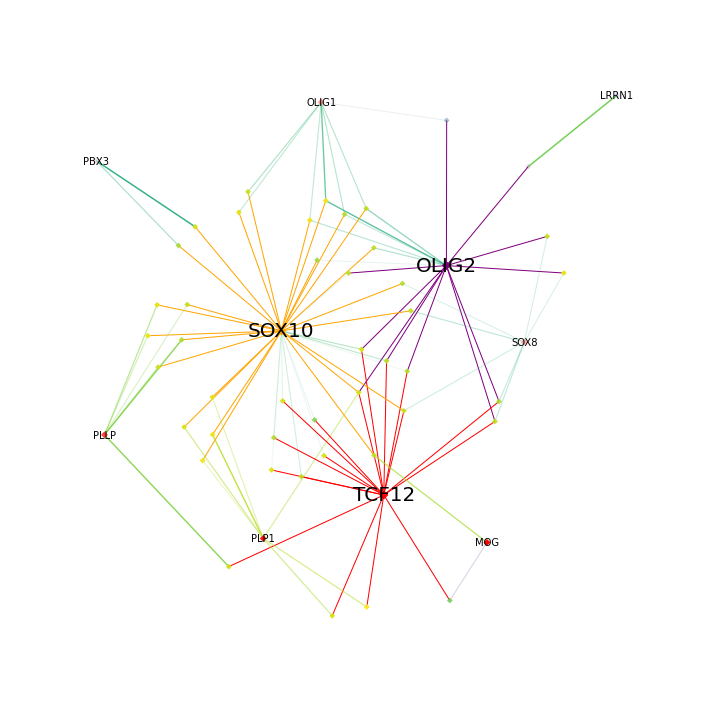

In [44]:
plt.figure(figsize=(10,10))
plot_networkx(G_kk, pos_kk)

In [14]:
export_to_cytoscape(G_kk, pos_kk,
                    '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/cytoscape/final_version_kk.cyjs', 
                    pos_scaling_factor=200, size_scaling_factor=1)

In [46]:
# Visualize with pyvis
import os
os.chdir('/data/leuven/313/vsc31305/jupyterhub_notebooks/Multiomics_pipeline/10x_human_cerebellum/')
from pyvis.network import Network
nt = Network(notebook=True)
nt.from_nx(G_kk)
nt.show_buttons()
nt.toggle_physics(False)
nt.show('nt.html')